## Initializations
Should only need to do these once.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

## Create a faculty candidate population
Here is a table that I've collected to motivate the distribution of areas that I'm using.

| Abbrev. | Field | # of PhDs (%) | # Faculty at ND (%) |
|------ | -------- | ----------- | --------------------- | 
| ast |Astrophysics|   166 (16%) | 8 (19%) |
| cmp | Condensed Matter Physics | 388 (38%) | 7 (17%) |
| hep | High-Energy Physics | 253 (25%) | 12 (28%) |
| net | Network Science (and/or Biophysics if you like) | 105 (10%) | 2 (5%) |
| nuc | Nuclear | 109 (11%) | 13 (31%) |
| -   | Total   | 1021 | 42 |

The "# of PhDs" column comes from an [AIP survey](https://www.aip.org/statistics/data-graphics/number-physics-phds-granted-subfield-physics-departments-classes-2010-2011) using data on graduates from 2010 and 2011.  I've only counted areas that we have in our department, and I've neglected AMO.  I'll use these numbers to sample candidates from.  The "# of Faculty at ND" column comes from counting up people in our department, including the 2020 retirements and also the recent HEP hire.  I'll use these numbers to set the fields in which we search (i.e. retirements proportional to group size).

For Theorist vs Experimentalist, I used the numbers from our department (which might not be typical), which gives a 2-to-1 ratio of experimentalists over theorists.

For the ratio of men to women, I'm just using the roughly [AIP statistics](https://www.aip.org/statistics/data-graphics/percent-phds-earned-women-selected-fields-classes-1981-through-2016) taken from an eyeball average of the most recent data points.

For the fraction of candidates who are Hispanic-American or African-American, I used the AIP statistics [here](https://www.aip.org/statistics/data-graphics/race-and-ethnicity-physics-phds-classes-2014-through-2016).

In [2]:
import faculty_hiring.models as fm
from collections import Counter
import logging

#fm.setup_logging(logging.DEBUG)

fields = {'AST-EX':0.107, 'AST-TH':0.053, 
          'CMP-EX':0.255, 'CMP-TH':0.125,
          'HEP-EX':0.167, 'HEP-TH':0.083,
          'BIO-EX':0.067, 'BIO-TH':0.033,  #Includes Network Science
          'NUC-EX':0.074, 'NUC-TH':0.036}

# Filled lines - The faculty we have in the department
filled_lines = Counter({'AST-EX':6, 'AST-TH':2, 
                        'CMP-EX':4, 'CMP-TH':2,
                        'HEP-EX':7, 'HEP-TH':5,
                        'BIO-EX':1, 'BIO-TH':2,  #Includes Network Science
                        'NUC-EX':10, 'NUC-TH':3})

# Open lines - lines we haven't managed to fill yet
open_lines = Counter({'AST-EX':0, 'AST-TH':0, 
                      'CMP-EX':3, 'CMP-TH':0,
                      'HEP-EX':0, 'HEP-TH':0,
                      'BIO-EX':0, 'BIO-TH':0,  #Includes Network Science
                      'NUC-EX':0, 'NUC-TH':0})

total_lines = filled_lines+open_lines

pop = fm.CandidatePopulation()
pop.add_attribute('field',fields)
pop.add_attribute('gender',{'M':0.8, 'F':0.2})
pop.add_attribute('URM',{'Y':0.02, 'N':0.98})

dep = fm.Department(pop, total_lines, open_lines)
dep.summary()

This department has 42 faculty and 3 unfilled lines.
Current Faculty:
----------------
age  experience  URM  field   gender  quality
---  ----------  ---  ------  ------  -------
 75          40  N    AST-EX  M          3.12
 72          39  Y    CMP-EX  M          3.35
 70          37  N    NUC-TH  M          3.22
 66          34  N    CMP-EX  F          3.91
 66          32  N    HEP-TH  M          3.94
 65          31  N    NUC-EX  M          3.12
 63          30  N    NUC-EX  M          3.47
 61          30  N    HEP-EX  F          3.89
 60          29  N    CMP-EX  M          3.07
 61          29  N    AST-TH  M          3.74
 64          29  N    NUC-EX  M          3.25
 60          28  N    AST-EX  M          3.28
 57          27  N    NUC-EX  F          3.29
 60          27  N    CMP-EX  M          3.26
 59          27  Y    NUC-EX  M          3.06
 60          27  N    AST-EX  M          3.37
 60          26  N    HEP-EX  M          3.58
 58          26  N    AST-TH  F        

## Running Searches

To carry out this study, I've created a model of a faculty department.  I run simulated hiring to fill out a department that has the same number of faculty as our department currently has as well as three open CMP-EX lines.  The department model includes such factors as randomized retirements for faculty over 65 years old, but not details like the possibility of not getting tenure or deciding to leave the univeristy for a different position.

Running a single year's worth of searches involves the following steps:
1. Advance the department by one year to trigger retirements.
1. Decide how many searches we'll run and in which fields.  This will be set by which lines are open and some constraints, like we can't have more than one CMP-EX search or two searches in other "EX" areas because of startup costs.
1. Generate the pool of candidates among which we're going to search.
1. Perform the searches, one at a time, marking the selected candidates.

We will run some number of years of searches (specified by `years`).  We will also run `n_trials` number of trials.  The goal is to see how the department evolves as well as how what the quality and demographics of the candidates hired are.

This set of searches will be targeted to a specific field and picking the best candidate regardless of gender or minority status.  In other words, business as usual.

Average quality: 3.42
Fraction of new hires that are female: 19.5%
Fraction of new hires that are URM: 2.1%


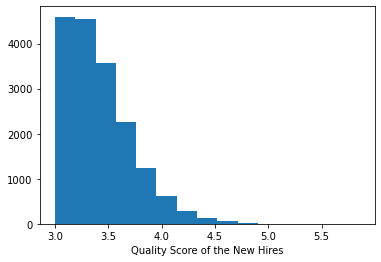

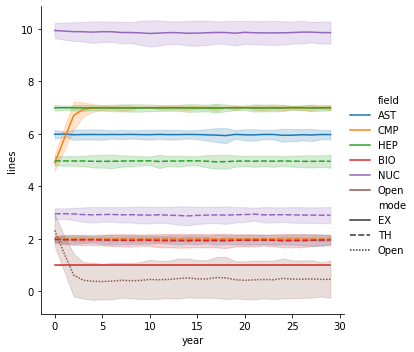

In [13]:
from faculty_hiring import strategy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Parameters of this study
years = 30 # The number of years to run searches for one trial
n_trials = 500 # The number of times to run the "years" string of searches
n_cands = 300 # Size of the candidate pool

# Keep some summary statistics
hire_quality_targeted = []
hire_gender = Counter()
hire_URM = Counter()
line_number = []
line_field = []
line_mode = []
line_year = []

for i in range(n_trials):
    # Make a new department.  Note, arguments here are defined above.
    dep = fm.Department(pop, total_lines, open_lines)

    for year in range(years):
        # Start a search cycle by advancing the department by one year.
        dep.next_year()

        # Let's decide how many searches to run
        searches = Counter(dep.unfilled_lines)  #We're making a copy so we don't accidentally modify it.

        # Place some caps depending on research area.  Yes, I know this isn't very elegant.
        if searches['AST-EX'] > 2:
            searches['AST-EX'] = 2
        if searches['BIO-EX'] > 1:
            searches['BIO-EX'] = 1
        if searches['CMP-EX'] > 1:
            searches['CMP-EX'] = 1
        if searches['HEP-EX'] > 2:
            searches['HEP-EX'] = 2
        if searches['NUC-EX'] > 2:
            searches['NUC-EX'] = 2
    
        # Generate our search list
        search_list = list(searches.elements())

        # There's only one population of candidates that all the searches draw from
        p = pop.generate_population(n_cands)
        
        for s in search_list:
            new_hire = strategy.pick_best(pop.record_type, p, {'field':s}, threshold=3.0)
            if new_hire != None:
                dep.add_faculty(new_hire)
                hire_quality_targeted.append(new_hire.quality)
                hire_gender[new_hire.gender]+=1
                hire_URM[new_hire.URM]+=1
        
        filled_lines = dep.lines - dep.unfilled_lines
        for f in filled_lines.keys():
            field, mode = f.split('-')
            line_number.append(filled_lines[f])
            line_field.append(field)
            line_mode.append(mode)
            line_year.append(year)
        unfilled = sum(dep.unfilled_lines.values())
        line_number.append(unfilled)
        line_field.append('Open')
        line_year.append(year)
        line_mode.append('Open')

hire_quality_targeted = np.array(hire_quality_targeted)
print('Average quality: {:.2f}'.format(np.mean(hire_quality_targeted)))
print('Fraction of new hires that are female: {:.1f}%'.format(100*hire_gender['F']/sum(hire_gender.values())))
print('Fraction of new hires that are URM: {:.1f}%'.format(100*hire_URM['Y']/sum(hire_URM.values())))
    
plt.hist(hire_quality_targeted,15)
plt.xlabel('Quality Score of the New Hires')

df = pd.DataFrame({'year':line_year, 'field':line_field, 'mode':line_mode, 'lines':line_number})
sns.relplot(x='year', y='lines', data=df, kind='line', hue='field', style='mode',ci="sd");

So, we can see here that the standard targeted approach results in very stable department composition, and hires URMs and women at the same rate at which they appear in the candidate population (or maybe just slighty less).

## Increasing Diversity
Let's try the same as above, but also prefer to hire candidates who are URMs or women.

Average quality: 3.41
Fraction of new hires that are female: 27.8%
Fraction of new hires that are URM: 3.8%


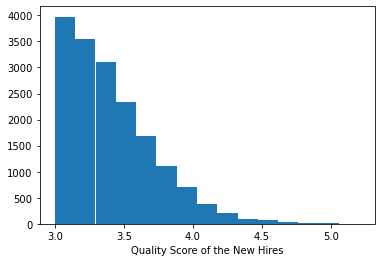

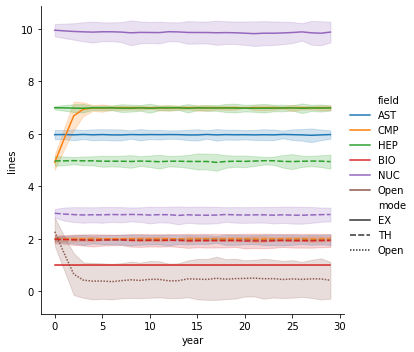

In [14]:
from faculty_hiring import strategy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Parameters of this study
years = 30 # The number of years to run searches for one trial
n_trials = 500 # The number of times to run the "years" string of searches
n_cands = 300 # Size of the candidate pool

# Keep some summary statistics
hire_quality_targeted_pref = []
hire_gender = Counter()
hire_URM = Counter()
line_number = []
line_field = []
line_mode = []
line_year = []

for i in range(n_trials):
    # Make a new department.  Note, arguments here are defined above.
    dep = fm.Department(pop, total_lines, open_lines)

    for year in range(years):
        # Start a search cycle by advancing the department by one year.
        dep.next_year()

        # Let's decide how many searches to run
        searches = Counter(dep.unfilled_lines)  #We're making a copy so we don't accidentally modify it.

        # Place some caps depending on research area.  Yes, I know this isn't very elegant.
        if searches['AST-EX'] > 2:
            searches['AST-EX'] = 2
        if searches['BIO-EX'] > 1:
            searches['BIO-EX'] = 1
        if searches['CMP-EX'] > 1:
            searches['CMP-EX'] = 1
        if searches['HEP-EX'] > 2:
            searches['HEP-EX'] = 2
        if searches['NUC-EX'] > 2:
            searches['NUC-EX'] = 2
    
        # Generate our search list
        search_list = list(searches.elements())

        # There's only one population of candidates that all the searches draw from
        p = pop.generate_population(n_cands)

        for s in search_list:
            new_hire = strategy.pick_pref(pop.record_type, p, [{'URM':'Y'},{'gender':'F'}], [0.5, 0.25], 
                                          filter_criteria={'field':s}, threshold=3.0)
            if new_hire != None:
                dep.add_faculty(new_hire)
                hire_quality_targeted_pref.append(new_hire.quality)
                hire_gender[new_hire.gender]+=1
                hire_URM[new_hire.URM]+=1
        
        filled_lines = dep.lines - dep.unfilled_lines
        for f in filled_lines.keys():
            field, mode = f.split('-')
            line_number.append(filled_lines[f])
            line_field.append(field)
            line_mode.append(mode)
            line_year.append(year)
        unfilled = sum(dep.unfilled_lines.values())
        line_number.append(unfilled)
        line_field.append('Open')
        line_year.append(year)
        line_mode.append('Open')

hire_quality_targeted_pref = np.array(hire_quality_targeted_pref)
print('Average quality: {:.2f}'.format(np.mean(hire_quality_targeted_pref)))
print('Fraction of new hires that are female: {:.1f}%'.format(100*hire_gender['F']/sum(hire_gender.values())))
print('Fraction of new hires that are URM: {:.1f}%'.format(100*hire_URM['Y']/sum(hire_URM.values())))
    
plt.hist(hire_quality_targeted_pref,15)
plt.xlabel('Quality Score of the New Hires')

df = pd.DataFrame({'year':line_year, 'field':line_field, 'mode':line_mode, 'lines':line_number})
sns.relplot(x='year', y='lines', data=df, kind='line', hue='field', style='mode',ci="sd");

Doing a targeted search in which we prefer to hire minorities and women results in a modest increase in the rate of hiring from both groups.  The average quality comes out about the same though.

## Open Search Targeting Diversity
Now, let's repeat the experiments above, but this time, let's search in all fields and likewise let's prioritize hiring women and URMs.

Average quality: 3.74
Fraction of new hires that are female: 35.9%
Fraction of new hires that are URM: 9.5%


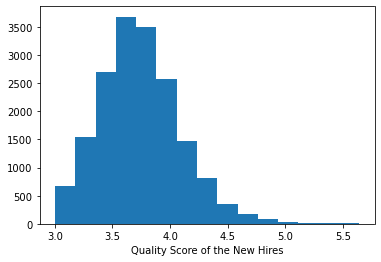

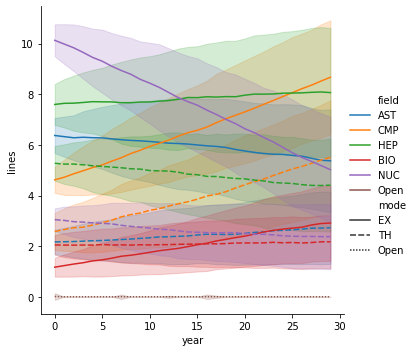

In [15]:
# Parameters of this study
years = 30 # The number of years to run searches for one trial
n_trials = 500 # The number of times to run the "years" string of searches
n_cands = 300 # Size of the candidate pool

# Keep some summary statistics
hire_quality_open_pref = []
hire_gender = Counter()
hire_URM = Counter()
line_number = []
line_field = []
line_mode = []
line_year = []

for i in range(n_trials):
    # Make a new department.  Note, arguments here are defined above.
    dep = fm.Department(pop, total_lines, open_lines)

    for year in range(years):
        # Start a search cycle by advancing the department by one year.
        dep.next_year()

        # Let's decide how many searches to run
        n_searches = min(6,sum(dep.unfilled_lines.values()))  # Arbitrarily capping number of searches at 6
        hire_fields = Counter()
        
        # There's only one population of candidates that all the searches draw from
        p = pop.generate_population(n_cands)
        
        for j in range(n_searches):
            # Use our original department makeup to determine the possible fields to search in
            search_fields = list(filled_lines.keys())
            # We can't necessarily afford to hire unlimited candidates in different fields, so limit some based on other hires in this cycle

            # Can't hire more than one CMP-EX or BIO-EX faculty member
            if hire_fields['BIO-EX']>0:
                search_fields.remove('BIO-EX')
            if hire_fields['CMP-EX']>0:
                search_fields.remove('CMP-EX')

            # Can't hire more than two of other experimentalists faculty member
            if hire_fields['AST-EX']>1:
                search_fields.remove('AST-EX')
            if hire_fields['HEP-EX']>1:
                search_fields.remove('HEP-EX')
            if hire_fields['NUC-EX']>1:
                search_fields.remove('NUC-EX')
            
            new_hire = strategy.pick_pref(pop.record_type, p, [{'URM':'Y'},{'gender':'F'}], [0.5, 0.25], 
                                          filter_criteria={'field':search_fields}, threshold=3.0)
            if new_hire != None:
                dep.add_faculty(new_hire)
                hire_fields[new_hire.field]+=1
                hire_quality_open_pref.append(new_hire.quality)
                hire_gender[new_hire.gender]+=1
                hire_URM[new_hire.URM]+=1
        
        filled_lines = dep.lines - dep.unfilled_lines
        for f in filled_lines.keys():
            field, mode = f.split('-')
            line_number.append(filled_lines[f])
            line_field.append(field)
            line_mode.append(mode)
            line_year.append(year)
        unfilled = sum(dep.unfilled_lines.values())
        line_number.append(unfilled)
        line_field.append('Open')
        line_year.append(year)
        line_mode.append('Open')

hire_quality_open_pref = np.array(hire_quality_open_pref)
print('Average quality: {:.2f}'.format(np.mean(hire_quality_open_pref)))
print('Fraction of new hires that are female: {:.1f}%'.format(100*hire_gender['F']/sum(hire_gender.values())))
print('Fraction of new hires that are URM: {:.1f}%'.format(100*hire_URM['Y']/sum(hire_URM.values())))
    
plt.hist(hire_quality_open_pref,15)
plt.xlabel('Quality Score of the New Hires')

df = pd.DataFrame({'year':line_year, 'field':line_field, 'mode':line_mode, 'lines':line_number})
sns.relplot(x='year', y='lines', data=df, kind='line', hue='field', style='mode',ci="sd");

These results are noticeably different from the ones above.  One the plus side, we're much more effective at hiring URMs and women.  We hire women at almost twice the fraction that they appear in the candidate population, and URMs are hired at more than three times their fraction in the candidate population.  Also, the average quality of hires is noticeably better than for the targeted searches.  However, the department composition shifts significantly over the course of the 30 years of hiring.  There is a fair amount of variability (the bands show the standard deviation of the number of faculty positions) but the overall trend are for the fraction of faculty in different fields to converge towards the fractions of candidates in the hiring pool in each of those fields.  In other words, our department following this strategy has no strategic plan.  One more thing worth noting although it doesn't jump out: The "open" lines plot is flat in this scenario, even though we start off the first year with 3 open CMP-EX lines and are only allowed to hire one CMP-EX candidate per year.  This is of course because in this scenario we don't care what fields we're hiring in, so we can go ahead and hire some of the cheaper fields to fill in the lines.

## Strategic Approach
So, if we want to try to gain the benefits in terms of flexibility and effectiveness of open hiring without losing the strategic goals of maintaining a distribution of lines, is there an approach that we can take?  I'm not sure, but let's try the following and see what happens:
1. Each hiring cycle, we will try to make enough hires to fill all open lines.
1. As we track open lines by field, we will allow the number of open lines to go negative, to a minimum value of -1.  This value maybe should be optimized, but let's start there.
1. Any field with more than -1 open lines will be included in the annual search.
1. We will give preference in hiring first to URM candidates, then women, then fields with positive number of open lines, sorted from most open lines to least.  The tolerance will depend on how "desperate" we are: URM will have a tolerance of 0.5, women will have a tolerance of 0.25, fields with open lines will have a tolerence of 0.25 unless they have more than two open lines, at which point, they get a tolerance of 0.5.
1. Although we'll do the searches one at a time, we'll re-evaluate the criteria, so that if, after hiring, say, and HEP-EX candidate, HEP-EX is now at -1 open lines, now HEP-EX will be removed from further hiring consideration that year.

Average quality: 3.62
Fraction of new hires that are female: 33.9%
Fraction of new hires that are URM: 7.6%


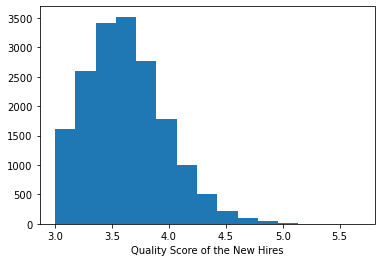

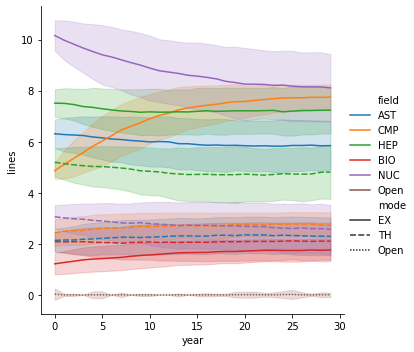

In [17]:
# Parameters of this study
years = 30 # The number of years to run searches for one trial
n_trials = 500 # The number of times to run the "years" string of searches
n_cands = 300 # Size of the candidate pool

# Keep some summary statistics
hire_quality_strat_pref = []
hire_gender = Counter()
hire_URM = Counter()
line_number = []
line_field = []
line_mode = []
line_year = []

for i in range(n_trials):
    # Make a new department.  Note, arguments here are defined above.
    dep = fm.Department(pop, total_lines, open_lines, minimum_open_lines=-1)

    for year in range(years):

        # Start a search cycle by advancing the department by one year.
        dep.next_year()

        # Let's decide how many searches to run
        n_searches = min(6,sum(dep.unfilled_lines.values()))  # Arbitrarily capping number of searches at 6
        hire_fields = Counter()        

        # There's only one population of candidates that all the searches draw from
        p = pop.generate_population(n_cands)

        for j in range(n_searches):
            # Decide in which fields we'll be searching and how we'll priorities
            prefs = [{'URM':'Y'}, {'gender':'F'}]
            tols = [0.5, 0.25]

            # We can't necessarily afford to hire unlimited candidates in different fields, so limit some based on other hires in this cycle
            search_fields = []
            field_list = list(dep.unfilled_lines.keys())
            value_list = list(dep.unfilled_lines.values())
            sort_list = np.argsort(value_list)
            for indx in reversed(sort_list):
                if value_list[indx] > -1:
                    search_fields.append(field_list[indx])
                    if value_list[indx] > 0:
                        prefs.append({'field':field_list[indx]})
                        tols.append(0.25 if value_list[indx] < 3 else 0.5)

            # Can't hire more than one CMP-EX or BIO-EX faculty member
            if (hire_fields['BIO-EX']>0) and ('BIO-EX' in search_fields):
                search_fields.remove('BIO-EX')
            if (hire_fields['CMP-EX']>0) and ('CMP-EX' in search_fields):
                search_fields.remove('CMP-EX')

            # Can't hire more than two of other experimentalists faculty member
            if (hire_fields['AST-EX']>1) and ('AST-EX' in search_fields):
                search_fields.remove('AST-EX')
            if (hire_fields['HEP-EX']>1) and ('HEP-EX' in search_fields):
                search_fields.remove('HEP-EX')
            if (hire_fields['NUC-EX']>1) and ('NUC-EX' in search_fields): 
                search_fields.remove('NUC-EX')
                        
            new_hire = strategy.pick_pref(pop.record_type, p, prefs, tols, 
                                          filter_criteria={'field':search_fields}, threshold=3.0)
            
            if new_hire != None:                
                dep.add_faculty(new_hire)
                hire_fields[new_hire.field]+=1
                hire_quality_strat_pref.append(new_hire.quality)
                hire_gender[new_hire.gender]+=1
                hire_URM[new_hire.URM]+=1
        
        filled_lines = dep.lines - dep.unfilled_lines
        for f in filled_lines.keys():
            field, mode = f.split('-')
            line_number.append(filled_lines[f])
            line_field.append(field)
            line_mode.append(mode)
            line_year.append(year)
        unfilled = sum(dep.unfilled_lines.values())
        line_number.append(unfilled)
        line_field.append('Open')
        line_year.append(year)
        line_mode.append('Open')

hire_quality_strat_pref = np.array(hire_quality_strat_pref)
print('Average quality: {:.2f}'.format(np.mean(hire_quality_strat_pref)))
print('Fraction of new hires that are female: {:.1f}%'.format(100*hire_gender['F']/sum(hire_gender.values())))
print('Fraction of new hires that are URM: {:.1f}%'.format(100*hire_URM['Y']/sum(hire_URM.values())))
    
plt.hist(hire_quality_strat_pref,15)
plt.xlabel('Quality Score of the New Hires')

df = pd.DataFrame({'year':line_year, 'field':line_field, 'mode':line_mode, 'lines':line_number})
sns.relplot(x='year', y='lines', data=df, kind='line', hue='field', style='mode',ci="sd");

There's a lot going on here.  First, we can note that the average quality is slightly worse than the completely open search approach, but still better than the targeted search.  Secondly, the rate of hiring URMs and women is quite close to the open search scenario and still noticeably better than the targeted search approach, even the case where we give preference to hiring URMs and women in a targeted search.  The lines are also more stable in this approach than in the open search approach, although the bands show there's still a significant amount of variation around those stable averages.  The "open lines" plot drops to zero immediately as we use the flexibility of this strategy to hire whichever candidates we can.  However, because we have a deficit in CMP-EX compared to the strategic plan, we do end up hiring CMP-EX faculty until we reach about the level in the strategic plan.  The NUC-EX faculty lines graph drops slightly over time.  Looking at what's happening in a few examples, this seems to be a consequence of the fact that there are significantly fewer nuclear candidates in the pool compared to the size of the nuclear group in our faculty.  Therefore, it's hard for them to produce competitive candidates as often as we might want to hire nuclear faculty, and other fields end up borrowing the lines to make "higher quality" and/or diversity hires.  A common list of "open" lines at the end of one of these searches will include several groups with `-1` open lines and the NUC-EX group with `2` open lines.  I suppose it is a matter of debate whether this property of this strategy is a "feature" or a "bug."  It could be tuned by adjusting the threshold for increasing the "prefernce tolerance" on candidates from groups that are behind in hiring.  For me, probably the most interesting thing is that even though we're not doing targeted searches in CMP-EX, we eventually get "caught up."  It takes longer than with the targeted searches, but we do get there.  It would be interesting to see what would happen if we started "behind" in HEP-EX (where we're close the the fraction in the candidate pool) or "NUC-EX" where we have more than the candidate pool.